# Example: Read a BPF file previously saved with fiberdesk.

First, import necessary libs.

In [5]:
import matplotlib
import struct
import numpy as np
import matplotlib.pyplot as plt
import array

Define the following class that "knows" how to read a fiberdesk file (old propagation file *.bpf)

In [6]:
class fiberdesk_bpf:
    def __init__(self, name):
        self.filename = name
        self.frame = 0
        self.bSecondFieldSaved = 0
        self.datapoints = 0
        self.time_intervall = 0.0
        self.spec_intervall = 0.0
        self.frequency_0 = 0.0
        self.distance = 0.0

        self.f = open(self.filename, 'rb')
        self.f.seek(-4, 2)  # from end, return by sizeof(int) to get frame number
        self.frames = struct.unpack('<i', self.f.read(4))[0]
        print('frames = ', self.frames)
        self.f.seek(0, 0)
        self.bSecondFieldSaved = struct.unpack('<i', self.f.read(4))[0]
        self.datapoints = struct.unpack('<i', self.f.read(4))[0]
        self.read_axis()

    def __del__(self):
        self.f.close()

    def read_str(self):
        # read CString written to file without putting it to memory
        strlen = struct.unpack('<B', self.f.read(1))[0]
        if (strlen == 255):
            strlen = struct.unpack('<H', self.f.read(2))[0]
        if (strlen == 65534):
            strlen = struct.unpack('<B', self.f.read(1))[
                0]  # as it should be for fiberdesk and stringslen < 255 in fiberdesk
        self.f.read(strlen * 2)

    def read_axis(self):
        self.read_str()  # axis title / ignored
        (_o, _number_of_datapoints, _decimal, _dmax, _dmin, self.frequency_0, _maticks, _miticks, _datapoints2,
         self.freq_intervall, self.time_intervall, _pow, _reverse, _show_title, _show_unit) = struct.unpack(
            '<iiidddddiddiiii', self.f.read(3 * 4 + 5 * 8 + 4 + 2 * 8 + 4 * 4))
        self.read_str()  # unit string / ignored
        wl = struct.unpack('<d', self.f.read(8))
        for i in range(3):
            (_od, _omt, _omx, _omi, _omit, _op, _or) = struct.unpack('<iddddii', self.f.read(44))
            self.read_str()
            self.read_str()

    def GetSavedFields(self):
        data = np.zeros((self.frames, self.datapoints), dtype=complex)
        print(data.shape)
        for i in range(self.frames):
            # read position
            acc_dist = struct.unpack('<d', self.f.read(8))
            cur_dist = struct.unpack('<d', self.f.read(8))
            if i == 0:
                self.distance = cur_dist[0]
            if i == self.frames - 1:
                self.distance = cur_dist[0] - self.distance
            irt_dist = struct.unpack('<d', self.f.read(8))
            io_rt = struct.unpack('<q', self.f.read(8))
            ii_rt = struct.unpack('<q', self.f.read(8))
            # data array
            f0 = struct.unpack('<d', self.f.read(8))
            fr = struct.unpack('<d', self.f.read(8))
            for c in range(self.datapoints):
                (real, imag) = struct.unpack('<dd', self.f.read(8 * 2))
                data[i][c] = real + 1j * imag
        return data

Now check out the following example reading in a propagation and plotting the temporal and spectral propagation.

frames =  101
(101, 2048)
(101, 2048)


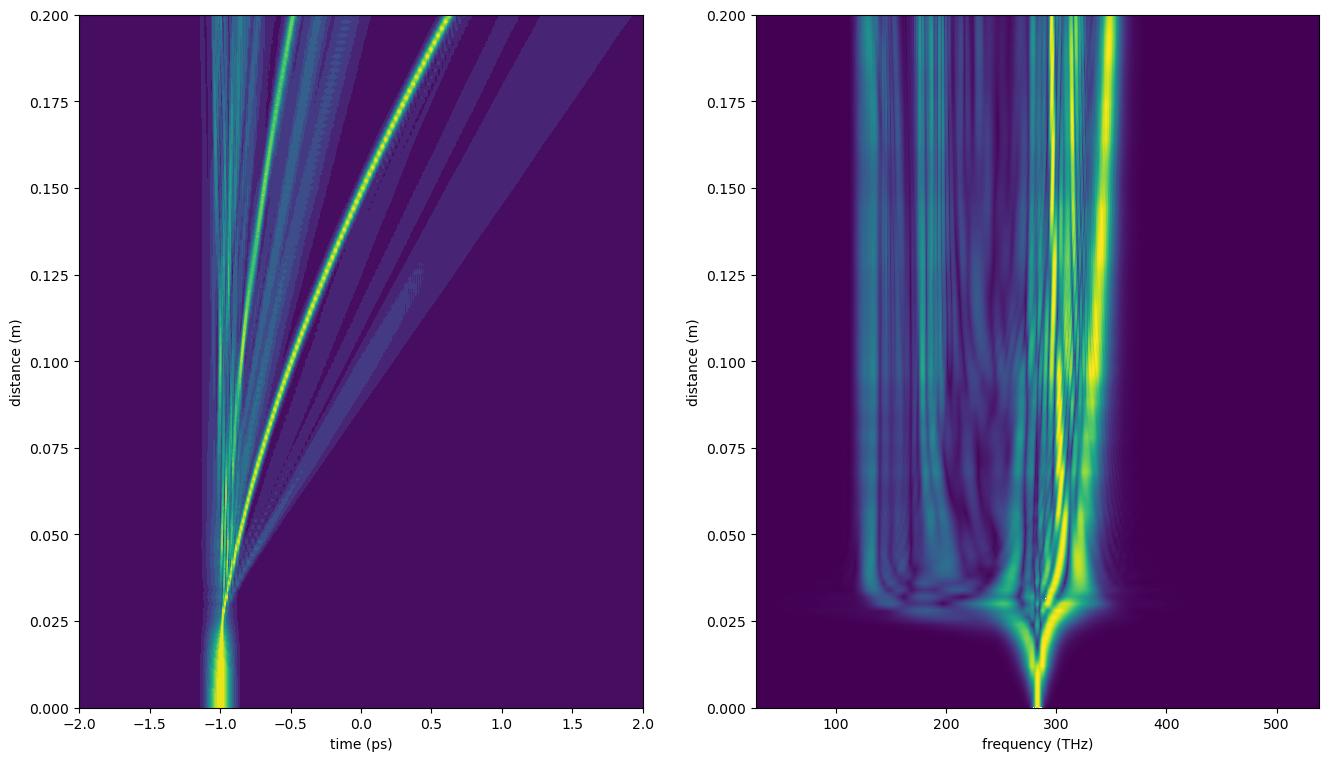

In [7]:
filename = r'propagation.bpf'

fd = fiberdesk_bpf(filename)
data_time = fd.GetSavedFields()

print(data_time.shape)
data_spec = np.copy(data_time)

for i in range(fd.frames):
    data_spec[i] = np.fft.ifftshift(np.fft.fft(data_time[i]))

N = fd.datapoints
t_min = -fd.time_intervall / 2.0 * 1e12  # ps
t_max = +fd.time_intervall / 2.0 * 1e12  # ps
s_min = (fd.frequency_0 - fd.freq_intervall / 2.0) * 1e-12
s_max = (fd.frequency_0 + fd.freq_intervall / 2.0) * 1e-12

# calc absolute values from complex array
field = np.abs(data_time)
# normalize each slice, remove if not required
for i in range(fd.frames):
    _max = np.max(field[i])
    if abs(_max) > 0.0:
        field[i] /= _max
# calc absolute values from complex array
spec = np.abs(data_spec)
# normalize each slice, remove if not required
for i in range(fd.frames):
    _max = np.max(spec[i])
    if abs(_max) > 0.0:
        spec[i] /= _max

fig1 = plt.figure(figsize=(16, 9), dpi=100)
ax = fig1.add_subplot(121)
bx = fig1.add_subplot(122)

colors = 16
levels = np.linspace(0.0, np.max(field), colors)
# draw the field
x = np.linspace(t_min, t_max, fd.datapoints)
y = np.linspace(0.0, fd.distance, fd.frames)
X, Y = np.meshgrid(x, y)
p1 = ax.contourf(X, Y, field, levels, extend='both')
ax.set_xlabel('time (ps)')
ax.set_ylabel('distance (m)')

# draw the spectrum
levels = np.linspace(0.0, np.max(spec), N)
x = np.linspace(s_min, s_max, fd.datapoints)
y = np.linspace(0.0, fd.distance, fd.frames)
X, Y = np.meshgrid(x, y)
p2 = bx.contourf(X, Y, spec, levels, extend='both')

bx.set_xlabel('frequency (THz)')
bx.set_ylabel('distance (m)')

plt.show()

That's it.